# Analyse des données

## Répartition des classes (Histogrammes)

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
from collections import defaultdict
import shutil
import random

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import img_to_array, load_img
from sklearn.model_selection import train_test_split

In [ ]:
# Configuration
dataset_path = "./Dataset/Dataset2/Noisy_photos"
img_size = (256, 256)  # Taille de l'image
num_samples = 6

# 1. Chargement et vérification des images
if not os.path.exists(dataset_path):
    raise FileNotFoundError(f"Dossier introuvable : {dataset_path}")

def load_images(folder_path, target_size=img_size):
    """Charge toutes les images en mémoire"""
    images = []
    valid_ext = ('.png', '.jpg', '.jpeg')
    
    for f in os.listdir(folder_path):
        if f.lower().endswith(valid_ext):
            img = Image.open(os.path.join(folder_path, f)).resize(target_size)
            images.append(np.array(img))
    
    if not images:
        raise ValueError("Aucune image valide trouvée")
    
    return np.array(images)

## Affichage d'échantillon de data

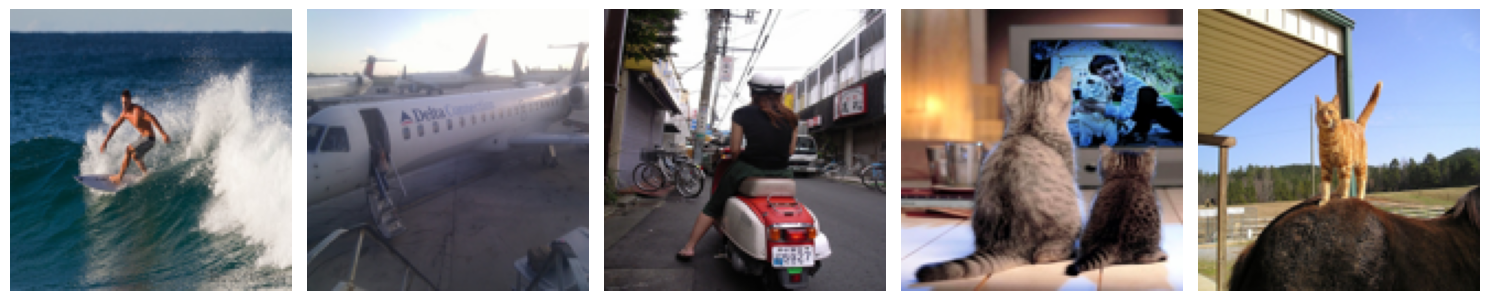

In [3]:
from PIL import Image  # Import the Image module from PIL

# 2. Chargement et affichage d'échantillon
all_images = load_images(dataset_path)

def display_images(images, num_samples=5):
    """Affiche un échantillon d'images"""
    plt.figure(figsize=(15, 5))
    for i in range(min(num_samples, len(images))):
        plt.subplot(1, num_samples, i+1)
        plt.imshow(images[i])
        plt.axis('off')
    plt.tight_layout()  # Ajout pour éviter le chevauchement
    plt.show()

# Appel de la fonction
display_images(all_images)

## Data Augmentation

In [4]:
# Nouvelle fonction de data augmentation
def augment_images(images, augment_factor=3): # Augmente le nombre d'images
    """Génère des images augmentées"""
    datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='reflect' #Les bords sont remplis par effet miroir : les valeurs de pixels sont copiées en sens inversé
    )
    
    augmented_images = []
    for img in images:
        img = img.reshape((1,) + img.shape)
        for _ in range(augment_factor):
            for batch in datagen.flow(img, batch_size=1):
                augmented_images.append(batch[0])
                break
    return np.array(augmented_images)

# Application avant le split
print("Augmentation des données...")
augmented_images = augment_images(all_images)
all_images = np.concatenate([all_images, augmented_images])
print(f"Nouveau nombre total d'images: {len(all_images)}")

Augmentation des données...
Nouveau nombre total d'images: 592


In [5]:
def preprocess_data(images):
    """Normalisation et redimensionnement"""
    images = images.astype('float32') / 255.  # Normalisation
    return images

# Split train/test
x_train, x_test = train_test_split(all_images, test_size=0.2, random_state=42)

# Application du prétraitement
x_train = preprocess_data(x_train)
x_test = preprocess_data(x_test)

print(f"\nForme des données :")
print(f"Train: {x_train.shape} (ex: {x_train[0].shape})")
print(f"Nombre d'images d'entrainement : {len(x_train) }")
print(f"Test: {x_test.shape} (ex: {x_test[0].shape})")
print(f"Nombre d'images test : {len(x_test) }")


Forme des données :
Train: (473, 128, 128, 3) (ex: (128, 128, 3))
Nombre d'images d'entrainement : 473
Test: (119, 128, 128, 3) (ex: (128, 128, 3))
Nombre d'images test : 119


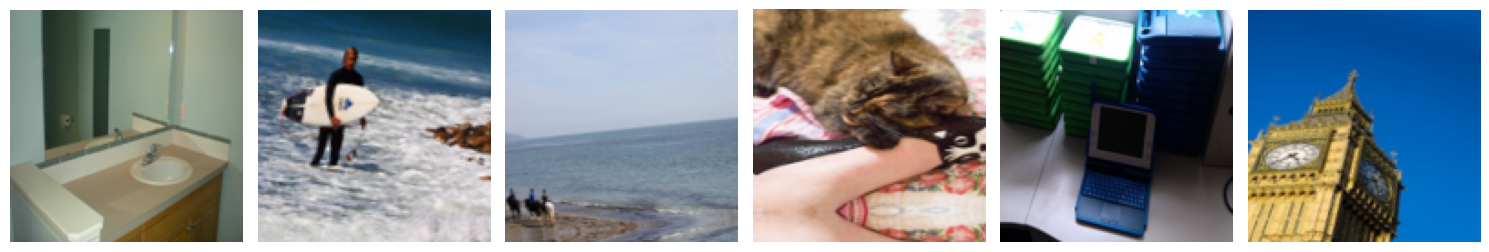

In [6]:
display_images(x_train, num_samples=6)  

## Auto-encodeur de réduction de bruit (denoiser)

In [7]:

def add_noise(images, noise_type="gaussian", noise_factor=0.3):
    noisy_images = images.copy()

    # if noise_type == "gaussian":
    #     noise = noise_factor * np.random.normal(loc=0.0, scale=1.0, size=images.shape)
    #     noisy_images += noise

    # elif noise_type == "poisson":
    #     noise = np.random.poisson(images * 255.0) / 255.0  # Convert to 0-1 range
    #     noisy_images += noise

    if noise_type == "speckle":
        noise = noise_factor * np.random.randn(*images.shape)
        noisy_images += images * noise

    # if noise_type == "salt_pepper":
    #     prob = noise_factor / 2
    #     rnd = np.random.rand(*images.shape)
    #     noisy_images[rnd < prob] = 0  # Sel (noir)
    #     noisy_images[rnd > (1 - prob)] = 1  # Poivre (blanc)

    return np.clip(noisy_images, 0., 1.)

# Appliquer plusieurs types de bruits
# x_train_noisy_gaussian = add_noise(x_train, "gaussian")
# x_test_noisy_gaussian = add_noise(x_test, "gaussian")

x_train_noisy_speckle = add_noise(x_train, "speckle")
x_test_noisy_speckle = add_noise(x_test, "speckle")

# x_train_noisy_sp = add_noise(x_train, "salt_pepper")
# x_test_noisy_sp = add_noise(x_test, "salt_pepper")

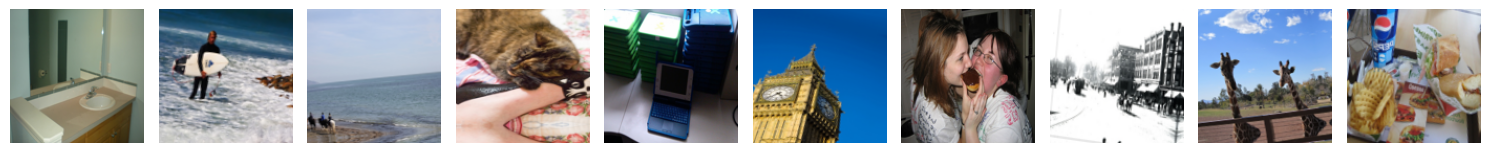

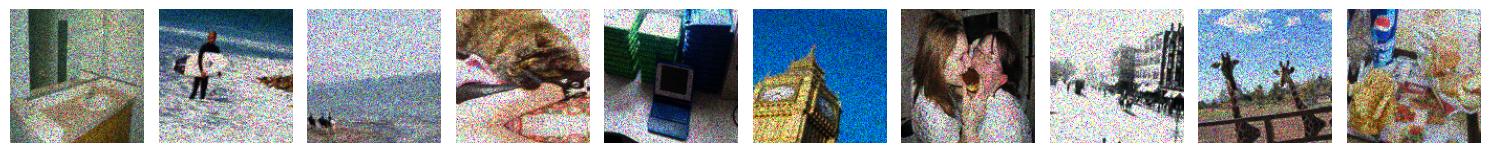

In [8]:
display_images(x_train, num_samples=10) 
# display_images(x_train_noisy_gaussian, num_samples=10) 
display_images(x_train_noisy_speckle, num_samples=10) 
# display_images(x_train_noisy_sp, num_samples=10) 



In [9]:
print("Dimensions des données :")
print("x_test shape:", x_test.shape)          # Doit être (N, 256, 256, 3)


Dimensions des données :
x_test shape: (119, 128, 128, 3)


In [10]:
# Configurations principales de nos modèles
IMG_SIZE          = img_size                # taille coté final d'une image en pixel (ici 28x28)
NB_EPOCHS_DENOISE = 50               # nombre epoch alogithme debruiter
BATCH_SIZE        = 32               # taille batch de traitement
SAV_MODEL_DENOISE = "denoiser2.h5"     # sauvegarde du modele de debruitage

## Encodeur

In [ ]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dropout, Input

# Entrée de l'image
input_img = Input(shape=(256, 256, 3))  # à adapter selon ta taille d’image

# Bloc 1
x = Conv2D(64, (3, 3), activation='relu', padding='same')(input_img)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2), padding='same')(x)

# Bloc 2
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2), padding='same')(x)

# Bloc 3
x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = Dropout(0.3)(x)
x = BatchNormalization()(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)



## Decodeur

In [12]:
from tensorflow.keras.layers import UpSampling2D, Dropout, Conv2D, BatchNormalization

# Bloc 1
x = Conv2D(256, (3, 3), activation='relu', padding='same')(encoded)
x = Dropout(0.3)(x)  # Dropout un peu plus fort ici car c’est la couche la plus profonde
x = BatchNormalization()(x)
x = UpSampling2D((2, 2))(x)

# Bloc 2
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = UpSampling2D((2, 2))(x)

# Bloc 3
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = UpSampling2D((2, 2))(x)

# Dernière couche (sortie)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)


In [13]:
from tensorflow.keras.models import Model

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mse')  # MSE au lieu de binary_crossentropy pour les images continues
autoencoder.summary()



Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 32, 32, 128)    │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 64, 64, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_2 (UpSampling2D)  │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 128, 128, 3)    │         1,73

 Total params: 1,335,043 (5.09 MB)

 Trainable params: 1,333,251 (5.09 MB)

 Non-trainable params: 1,792 (7.00 KB)

## Entrainement

In [14]:
%reload_ext tensorboard

In [17]:

# history = autoencoder.fit(
    # x_train_noisy_gaussian, x_train,
    # epochs=50,
    # batch_size=64,
    # shuffle=True,
    # validation_data=(x_test_noisy_gaussian, x_test)
# )

history_speckle = autoencoder.fit(
    x_train_noisy_speckle, x_train,
    epochs=50,
    batch_size=64,
    shuffle=True,
    validation_data=(x_test_noisy_speckle, x_test)
)

# history_sp = autoencoder.fit(
#     x_train_noisy_sp, x_train,
#     epochs=50,
#     batch_size=32,
#     shuffle=True,
#     validation_data=(x_test_noisy_sp, x_test)
# )


Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 28s 3s/step - loss: 0.0740 - val_loss: 0.1450
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 24s 3s/step - loss: 0.0183 - val_loss: 0.1297
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 24s 3s/step - loss: 0.0143 - val_loss: 0.1041
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 24s 3s/step - loss: 0.0128 - val_loss: 0.0852
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 24s 3s/step - loss: 0.0117 - val_loss: 0.0600
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 24s 3s/step - loss: 0.0118 - val_loss: 0.0532
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 24s 3s/step - loss: 0.0108 - val_loss: 0.0475
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 24s 3s/step - loss: 0.0100 - val_loss: 0.0451
Epoch 9/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 24s 3s/step - loss: 0.0098 - val_loss: 0.0484
Epoch 10/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 24s 3s/step - loss: 0.0100 - val_loss: 0.0520
Epoch 11/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 24s 3s/step - loss: 0.0095 - val_loss: 0.0705
Epoch 12/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 24s 3s/step - loss: 0.0094 - val_loss: 0.0489
Epoch 13/50
8

C:\Users\Ahmed AMARA\AppData\Local\Temp\ipykernel_19512\1545710763.py:4: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


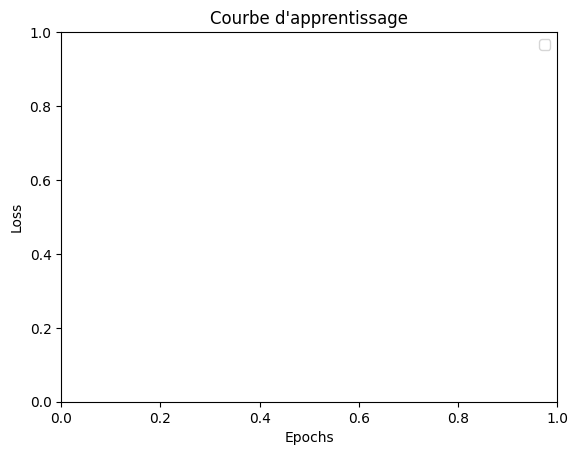

<Figure size 1000x500 with 0 Axes>

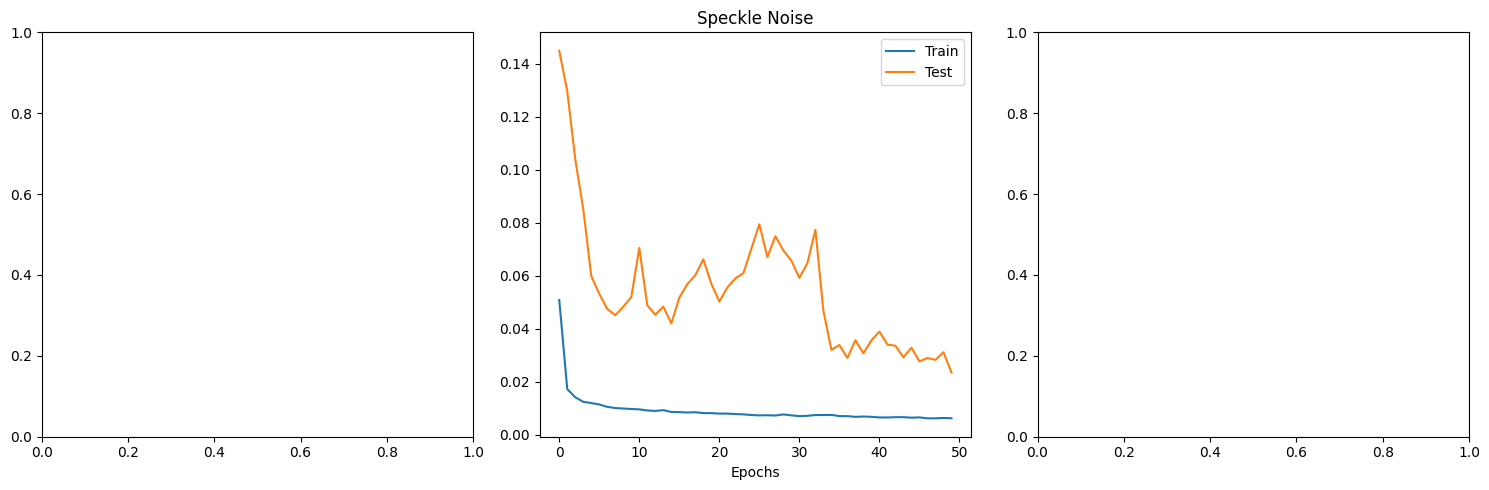

In [20]:
# Visualisation des pertes d'apprentissage (Train) et de validation (Test)
# plt.plot(history.history['loss'], label='train')  # Pertes d'apprentissage
# plt.plot(history.history['val_loss'], label='test')  # Pertes de validation
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Courbe d\'apprentissage')
plt.show()
plt.figure(figsize=(10, 5))

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Gaussian Noise
# axes[0].plot(history.history['loss'], label='Train')
# axes[0].plot(history.history['val_loss'], label='Test')
# axes[0].set_title("Gaussian Noise")
# axes[0].set_xlabel('Epochs')
# axes[0].set_ylabel('Loss')
# axes[0].legend()

# Speckle Noise
axes[1].plot(history_speckle.history['loss'], label='Train')
axes[1].plot(history_speckle.history['val_loss'], label='Test')
axes[1].set_title("Speckle Noise")
axes[1].set_xlabel('Epochs')
axes[1].legend()

# Salt & Pepper Noise
# axes[2].plot(history_sp.history['loss'], label='Train')
# axes[2].plot(history_sp.history['val_loss'], label='Test')
# axes[2].set_title("Salt & Pepper Noise")
# axes[2].set_xlabel('Epochs')
# axes[2].legend()

plt.tight_layout()
plt.show()


In [21]:
# autoencoder.save(SAV_MODEL_DENOISE)  # Sauvegarde du modèle

In [22]:
print("Dimensions des données :")
print("x_test shape:", x_test.shape)          # Doit être (N, 256, 256, 3)

print("Modèle input shape:", autoencoder.input_shape)  # Doit être (None, 256, 256, 3)

Dimensions des données :
x_test shape: (119, 128, 128, 3)
Modèle input shape: (None, 128, 128, 3)


In [23]:
def visualize_denoising(model, clean_images, noisy_images, num_samples=3):
    """Version corrigée avec affichage garanti"""
    # 1. Vérification des entrées
    num_samples = min(num_samples, len(clean_images))
    print(f"\nVisualisation de {num_samples} échantillons...")
    
    # 2. Prédiction
    try:
        denoised = model.predict(noisy_images[:num_samples], verbose=0)
        print("Prédiction réussie. Shapes :")
        print(f"- Original : {clean_images[0].shape}")
        print(f"- Bruité : {noisy_images[0].shape}")
        print(f"- Débruité : {denoised[0].shape}")
    except Exception as e:
        print("\nÉchec de prédiction :")
        print(f"Erreur : {str(e)}")
        print("Vérifiez que :")
        print("- Le modèle est compilé")
        print("- noisy_images.shape =", noisy_images.shape)
        print("- model.input_shape =", model.input_shape)
        return

    # 3. Configuration du plot
    plt.figure(figsize=(15, 8), dpi=100)  # Augmentation de la résolution
    
    # 4. Affichage des images
    for i in range(num_samples):
        # Calcul des métriques
        try:
            psnr_n = psnr(clean_images[i], noisy_images[i])
            psnr_d = psnr(clean_images[i], denoised[i])
        except:
            psnr_n = psnr_d = float('nan')  # En cas d'échec du calcul
        
        # Original
        plt.subplot(3, num_samples, i+1)
        plt.imshow(clean_images[i].squeeze(), cmap='gray' if clean_images[i].shape[-1] == 1 else None)
        plt.title(f"Original\nPSNR: ∞ dB", fontsize=8)
        plt.axis('off')
        
        # Bruité
        plt.subplot(3, num_samples, i+1+num_samples)
        plt.imshow(noisy_images[i].squeeze(), cmap='gray' if noisy_images[i].shape[-1] == 1 else None)
        plt.title(f"Noisy\nPSNR: {psnr_n:.2f} dB", fontsize=8)
        plt.axis('off')
        
        # Débruité
        plt.subplot(3, num_samples, i+1+2*num_samples)
        plt.imshow(denoised[i].squeeze(), cmap='gray' if denoised[i].shape[-1] == 1 else None)
        plt.title(f"Denoised\nPSNR: {psnr_d:.2f} dB", fontsize=8)
        plt.axis('off')

    # 5. Affichage final
    plt.tight_layout()
    plt.show()
    print("Visualisation terminée!")


In [ ]:
print("Dimensions des données :")
print("x_test shape:", x_test.shape)          # Doit être (N, 256, 256, 3)
# print("x_test_noisy shape:", x_test_noisy_gaussian.shape)  # Doit être (N, 256, 256, 3)
# print("x_test_noisy shape:", x_test_noisy_sp.shape)  # Doit être (N, 256, 256, 3)
print("x_test_noisy shape:", x_train_noisy_speckle.shape)  # Doit être (N, 256, 256, 3)

print("Modèle input shape:", autoencoder.input_shape)  # Doit être (None, 256, 256, 3)

Dimensions des données :
x_test shape: (119, 128, 128, 3)
x_test_noisy shape: (473, 128, 128, 3)
Modèle input shape: (None, 128, 128, 3)



Visualisation de 3 échantillons...
Prédiction réussie. Shapes :
- Original : (128, 128, 3)
- Bruité : (128, 128, 3)
- Débruité : (128, 128, 3)


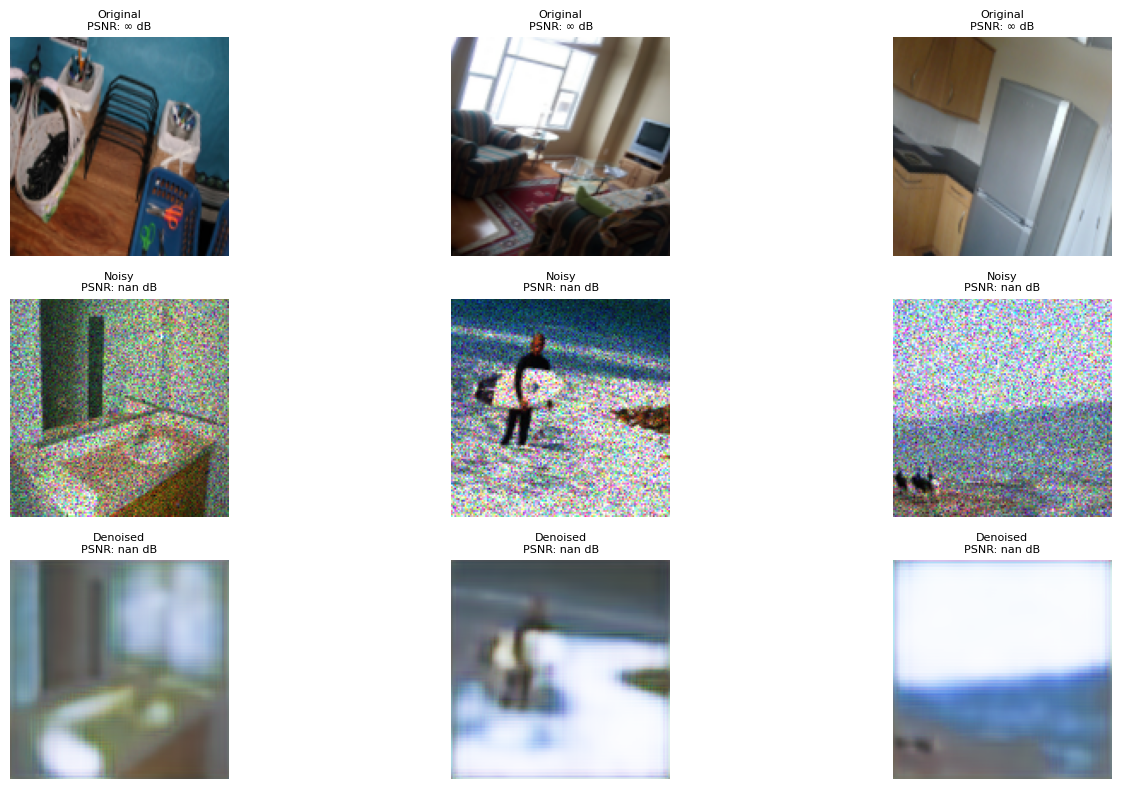

Visualisation terminée!


In [29]:
# # Test minimal
# print("=== Test de visualisation ===")
# print("x_test shape:", x_test.shape)          # Doit être (N, 256, 256, 3)
# # print("x_test_noisy shape:", x_test_noisy_gaussian.shape)  # Doit être (N, 256, 256, 3)
# # print("x_test_noisy shape:", x_test_noisy_sp.shape)  # Doit être (N, 256, 256, 3)
visualize_denoising(autoencoder, x_test[:3], x_train_noisy_speckle[:3])  # Test avec 3 échantillons
# visualize_denoising(autoencoder, x_test[:3], x_train_noisy_sp[:4])  # Test avec 3 échantillons